In [1]:
from IPython.display import Markdown, Latex
displaym = lambda markdown : display(Markdown(markdown))
from sklearn.cluster import AgglomerativeClustering
from spotifyUtil import get_spotify_client, plot_dendrogram
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure
from scipy.cluster import hierarchy
spotify = get_spotify_client()
import matplotlib.pyplot as plt
from scipy.stats import zscore
from datetime import datetime
import pandas as pd
import numpy as np

Using `localhost` as redirect URI without a port. Specify a port (e.g. `localhost:8080`) to allow automatic retrieval of authentication code instead of having to copy and paste the URL your browser is redirected to.


Enter the URL you were redirected to:  http://localhost/?code=AQDNgPpQ4HLc5EgRyPQbi7GP19m040_EVuA0WCfdkoIZ8tRRgYGBae1usAYWpA6dO1eTX8dt-iuiqDAlDGy-hXAlsw1wBdOgqUA_cvbIZBpuiOTLFhIdD8JDI_fraZK-jGkEhvpx6qAE-Al59rwarCJ2_PEFHOlwIqg8nkZUsfMDexzylNPaTYMadFwE


---
# Collect All My Playlists

In [2]:
my_playlists = []
offset = 0
append_playlists = spotify.current_user_playlists(offset=offset)["items"]
while len(append_playlists) > 0:
    my_playlists += append_playlists
    offset += len(append_playlists)
    append_playlists = spotify.current_user_playlists(offset=offset)["items"]
displaym("""
## My Playlists  
Collected **{}** playlists
""".format(
    len(my_playlists)
))


## My Playlists  
Collected **33** playlists


---
# Union **WoofBeats&trade;** Playlists and Add Track Features

In [3]:
WoofBeats_playlists = [
    p for p in my_playlists 
    if "WoofBeats" in p["name"] and "20" in p["name"]
]

# get tracks
for playlist in WoofBeats_playlists:
    playlist.update({
        "tracks":spotify.playlist_tracks(playlist["id"]) 
    })

displaym(
"""
## List **WoofBeats&trade;** Playlists
 - {}
---
""".format(
    " \n- ".join([
        "{}: **{}** songs".format(
            playlist["name"], 
            len(playlist["tracks"]["items"])
        ) 
        for playlist in WoofBeats_playlists
    ])
))


## List **WoofBeats&trade;** Playlists
 - WoofBeats-2021-12: **26** songs 
- WoofBeats-2021-11: **23** songs 
- WoofBeats-2021-10: **27** songs 
- WoofBeats-2021-07: **30** songs 
- WoofBeats-2021-05: **37** songs 
- WoofBeats-2021-04: **50** songs 
- WoofBeats-2021-03: **38** songs 
- WoofBeats-2021-02: **45** songs 
- WoofBeats-2021-01: **56** songs 
- WoofBeats-2020-12: **46** songs
---


## Add Track Features

In [4]:
WoofBeats_tracks = [
    {
        "playlist_name": playlist["name"],
        "playlist_id": playlist["id"],
        "added_by": track["added_by"]["id"],
        **track["track"]
    }
    for playlist in WoofBeats_playlists
    for track in playlist["tracks"]["items"]
]

WoofBeats_tracks = [
    {
        "track_id" : track["id"],
        "track_name" :track["name"],
        "track_duration_ms" : track["duration_ms"],
        "track_popularity" : track["popularity"],
        "track_explicit" : track["explicit"],
        **{
            "track_" + key:value 
            for key, value in spotify.audio_features([track["id"]])[0].items()
        },
        "album_name" : track["album"]["name"],
        "album_release_timestamp" : pd.to_datetime(track["album"]["release_date"]).timestamp(),
        "album_id" : track["album"]["id"],
        "artist_id" : track["artists"][0]["id"],
        "artist_name" : track["artists"][0]["name"],
        "playlist_name" : track["playlist_name"],
        "playlist_id" : track["playlist_id"],
        "added_by": track["added_by"]
    }
    for track in WoofBeats_tracks
]

added_by_map = {
    "12167264510" : "Dakota",
    "12145760918" : "Dan"
}

for track in WoofBeats_tracks:
    added_by = track["added_by"]
    track["added_by"] = added_by_map[added_by] if added_by in added_by_map else added_by

for track in WoofBeats_tracks:
    for key in [
        "track_type",
        "track_uri",
        "track_track_href",
        "track_analysis_url",
        ]:
        del track[key]
        
WoofBeats_df = pd.DataFrame(WoofBeats_tracks)
display(WoofBeats_df.info())
display(WoofBeats_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   track_id                 378 non-null    object 
 1   track_name               378 non-null    object 
 2   track_duration_ms        378 non-null    int64  
 3   track_popularity         378 non-null    int64  
 4   track_explicit           378 non-null    bool   
 5   track_danceability       378 non-null    float64
 6   track_energy             378 non-null    float64
 7   track_key                378 non-null    int64  
 8   track_loudness           378 non-null    float64
 9   track_mode               378 non-null    int64  
 10  track_speechiness        378 non-null    float64
 11  track_acousticness       378 non-null    float64
 12  track_instrumentalness   378 non-null    float64
 13  track_liveness           378 non-null    float64
 14  track_valence            3

None

,track_id,track_name,track_duration_ms,track_popularity,track_explicit,track_danceability,track_energy,track_key,track_loudness,track_mode,...,track_tempo,track_time_signature,album_name,album_release_timestamp,album_id,artist_id,artist_name,playlist_name,playlist_id,added_by
0,7Fk0zNC7vGdoDwePPgByKh,Peaches N Cream (feat. Charlie Wilson),284213,43,False,0.830,0.722,0,-6.099,1,...,109.987,4,Peaches N Cream (feat. Charlie Wilson),1.425946e+09,0tKHgjptFpCMWQyKrwThXF,7hJcb9fa4alzcOq3EaNPoG,Snoop Dogg,WoofBeats-2021-12,4Wj5LF1wo57BP6Fk2Itzk9,davidmimorton
1,32YOyb6WzKcHHWOPNBndvL,the astronaut,185078,35,False,0.559,0.343,7,-9.155,1,...,166.034,4,the astronaut,1.617667e+09,2vZMnfL7DLYTIGiz3piGn7,7BexBpZwJEohkHnOeuXDoi,Ray Goren,WoofBeats-2021-12,4Wj5LF1wo57BP6Fk2Itzk9,Dan
2,0ssRH9I8P7X7tawJQiIhzE,1993 (feat. Little Ricky ZR3),159832,53,True,0.701,0.676,9,-5.873,1,...,105.041,4,Ugly is Beautiful,1.594944e+09,1HmWQo43Gt8BR2dylfv3o4,6TLwD7HPWuiOzvXEa3oCNe,Oliver Tree,WoofBeats-2021-12,4Wj5LF1wo57BP6Fk2Itzk9,Dan
3,2KUyYDas5sAAulThIiZBO5,Brass,151380,41,True,0.775,0.890,2,-4.574,0,...,142.948,4,Brass,1.577059e+09,1ZRprAbchzdVCZZnH9BaDQ,22KyrgRdE2K6aB5wtZls3c,AG Club,WoofBeats-2021-12,4Wj5LF1wo57BP6Fk2Itzk9,Dakota
4,3sN85u5M7FoMmHa8E2aViO,Heybb!,148608,59,False,0.654,0.972,6,-2.872,0,...,117.009,4,Heybb!,1.571270e+09,5CfgvNG8Y0ZGXAx3rNvjC8,2jbd7OqeJJd1hz81vOXwwW,binki,WoofBeats-2021-12,4Wj5LF1wo57BP6Fk2Itzk9,Dakota



### Feature Summary: **track duration ms**  
 - Mean: 219500.299
 - Std: 68144.476
 - Range: 99289 - 662773
 - Width: 563484

        

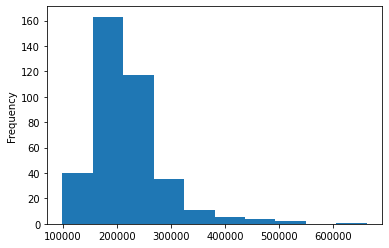

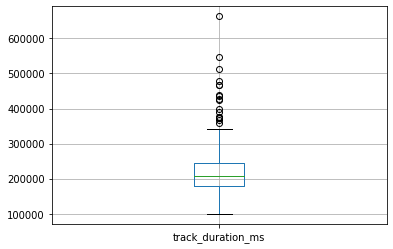


### Feature Summary: **track popularity**  
 - Mean: 47.196
 - Std: 19.661
 - Range: 0 - 83
 - Width: 83

        

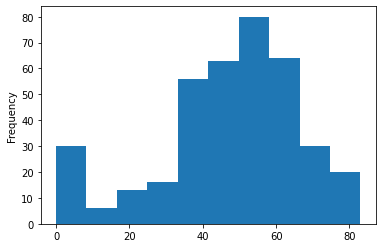

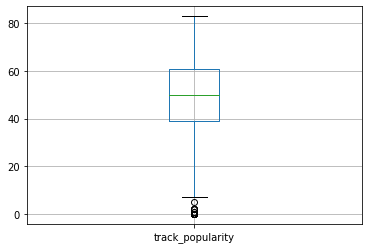


### Feature Summary: **track danceability**  
 - Mean: 0.642
 - Std: 0.143
 - Range: 0.229 - 0.964
 - Width: 0.735

        

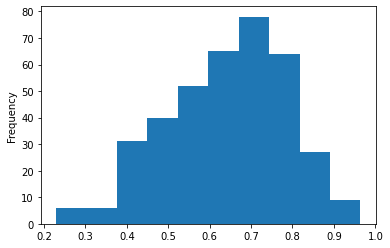

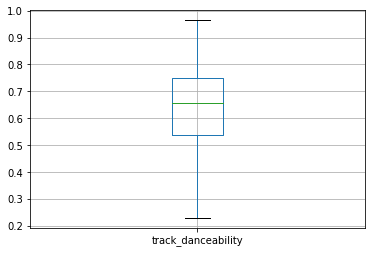


### Feature Summary: **track energy**  
 - Mean: 0.689
 - Std: 0.153
 - Range: 0.221 - 0.981
 - Width: 0.76

        

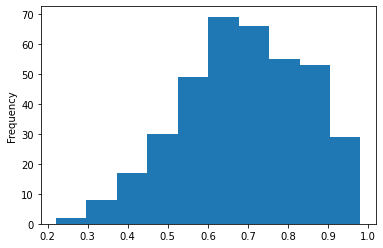

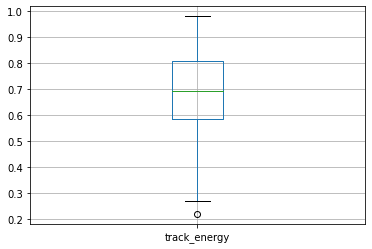


### Feature Summary: **track key**  
 - Mean: 5.386
 - Std: 3.472
 - Range: 0 - 11
 - Width: 11

        

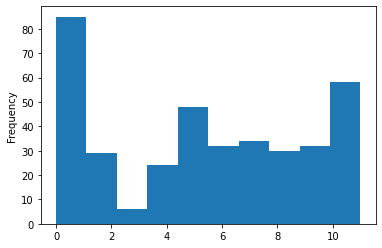

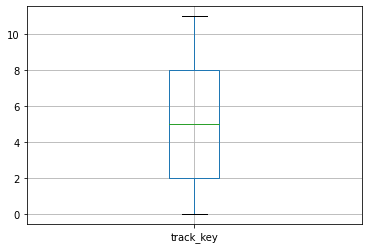


### Feature Summary: **track loudness**  
 - Mean: -6.352
 - Std: 2.208
 - Range: -14.431 - -0.868
 - Width: 13.563

        

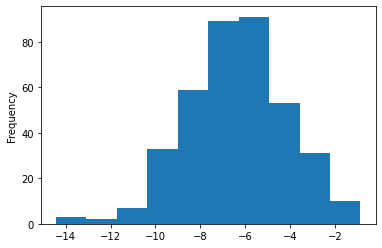

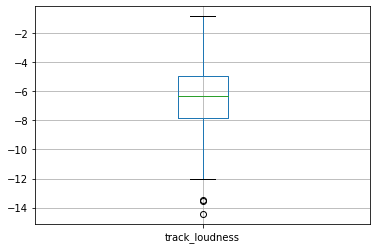


### Feature Summary: **track mode**  
 - Mean: 0.561
 - Std: 0.497
 - Range: 0 - 1
 - Width: 1

        

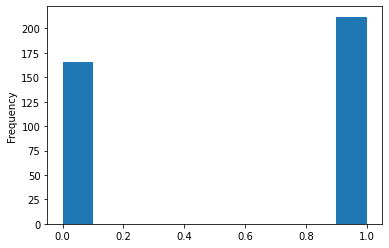

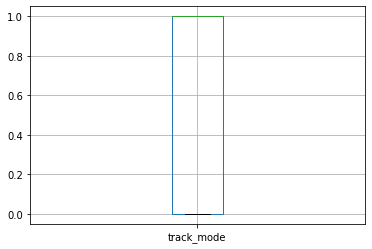


### Feature Summary: **track speechiness**  
 - Mean: 0.153
 - Std: 0.128
 - Range: 0.026 - 0.545
 - Width: 0.519

        

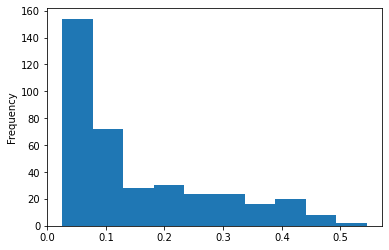

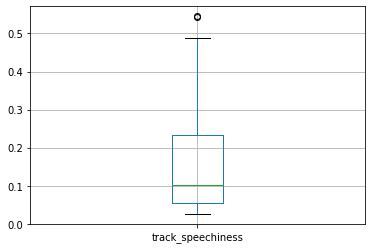


### Feature Summary: **track acousticness**  
 - Mean: 0.169
 - Std: 0.195
 - Range: 0.0 - 0.923
 - Width: 0.923

        

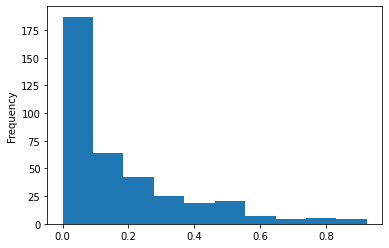

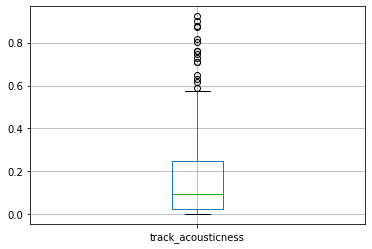


### Feature Summary: **track instrumentalness**  
 - Mean: 0.039
 - Std: 0.143
 - Range: 0.0 - 0.911
 - Width: 0.911

        

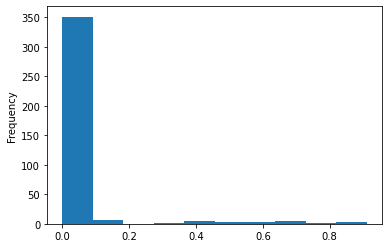

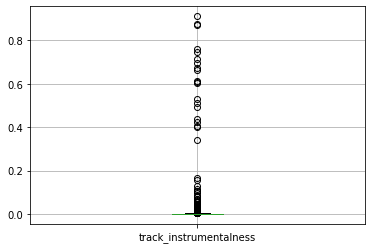


### Feature Summary: **track liveness**  
 - Mean: 0.216
 - Std: 0.163
 - Range: 0.026 - 0.821
 - Width: 0.795

        

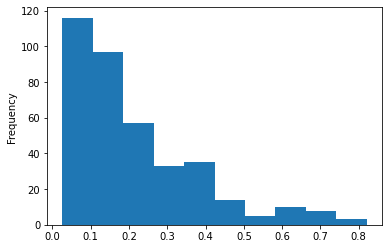

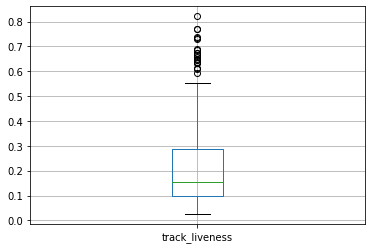


### Feature Summary: **track valence**  
 - Mean: 0.517
 - Std: 0.22
 - Range: 0.037 - 0.968
 - Width: 0.931

        

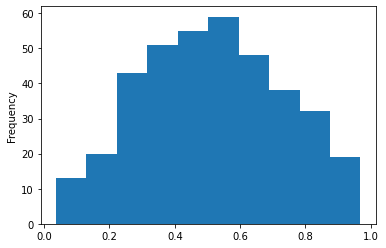

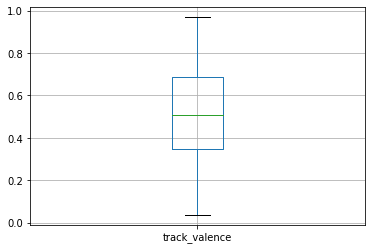


### Feature Summary: **track tempo**  
 - Mean: 120.168
 - Std: 30.954
 - Range: 64.474 - 206.68
 - Width: 142.206

        

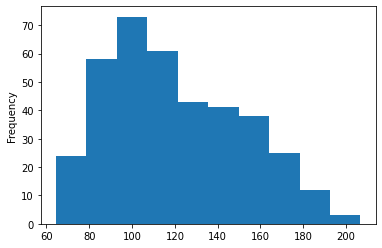

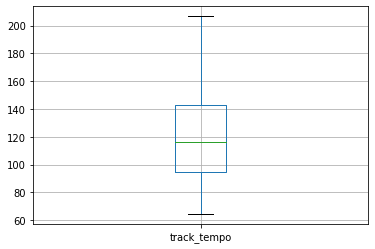


### Feature Summary: **track time signature**  
 - Mean: 3.984
 - Std: 0.205
 - Range: 3 - 5
 - Width: 2

        

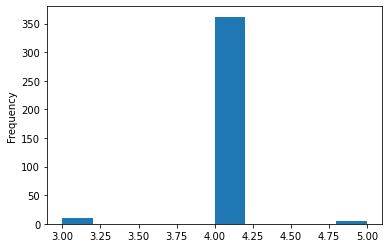

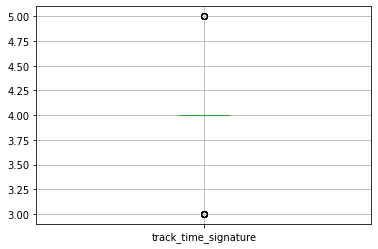


### Feature Summary: **album release timestamp**  
 - Mean: 1450263085.714
 - Std: 282709959.663
 - Range: -100310400.0 - 1637539200.0
 - Width: 1737849600.0

        

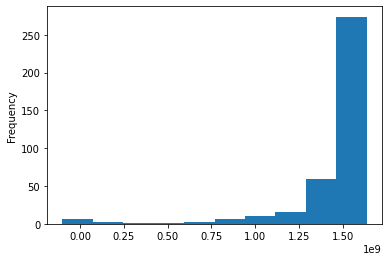

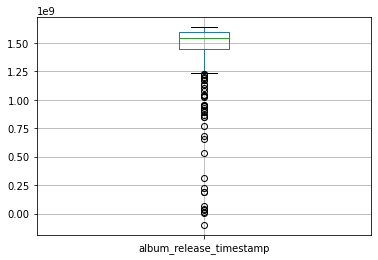

In [5]:
plt.rcParams["figure.figsize"] = (8,4)
for col in WoofBeats_df.columns:
    if type(WoofBeats_df[col][0]) in [np.float64, np.int64]:
        displaym("""
### Feature Summary: **{}**  
 - Mean: {}
 - Std: {}
 - Range: {} - {}
 - Width: {}

        """.format(
            col.replace("_"," "),
            round(WoofBeats_df[col].mean(),3),
            round(WoofBeats_df[col].std(),3),
            round(min(WoofBeats_df[col]),3),
            round(max(WoofBeats_df[col]),3),
            round(max(WoofBeats_df[col]) - min(WoofBeats_df[col]),3)
        ))
        WoofBeats_df[col].plot.hist()
        plt.show()
        WoofBeats_df.boxplot(col)
        plt.show()


### Feature Summary: **album name**  
 - Most Common: Complicate Your Life with Violence
 - Least Common: u and me, but mostly me (deluxe)
    

,0
album_name,
Complicate Your Life with Violence,3
Operation: Wake Up,3
Sensational,3
Ugly is Beautiful,3
Gooey,3



### Feature Summary: **artist name**  
 - Most Common: Yung Gravy
 - Least Common: slowthai
    

,0
artist_name,
Yung Gravy,10
A$AP Rocky,9
Mac Miller,7
Glass Animals,6
Eminem,6



### Feature Summary: **playlist name**  
 - Most Common: WoofBeats-2021-01
 - Least Common: WoofBeats-2021-11
    

,0
playlist_name,
WoofBeats-2021-01,56
WoofBeats-2021-04,50
WoofBeats-2020-12,46
WoofBeats-2021-02,45
WoofBeats-2021-03,38


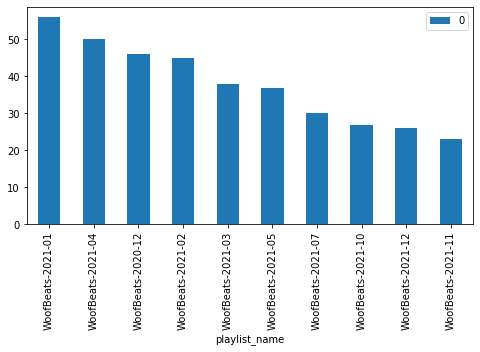


### Feature Summary: **added by**  
 - Most Common: davidmimorton
 - Least Common: beet1eman
    

,0
added_by,
davidmimorton,135
Dan,121
Dakota,118
1243264703,2
beet1eman,2


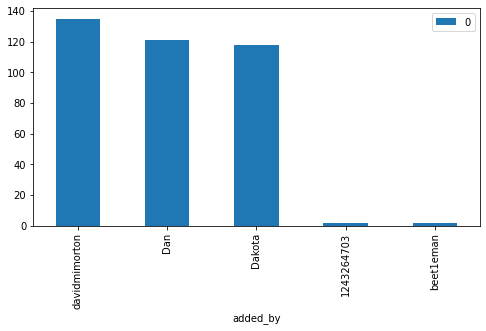

In [6]:
plt.rcParams["figure.figsize"] = (8,4)

categorical_features = [
    "album_name",
    "artist_name",
    "playlist_name",
    "added_by"
]

for col in categorical_features:
    sorted_categories = WoofBeats_df[[col]].groupby(col) \
            .size() \
            .sort_values(ascending=False) \
            .reset_index(col) \
            .set_index(col)
    
    displaym("""
### Feature Summary: **{}**  
 - Most Common: {}
 - Least Common: {}
    """.format(
        col.replace("_"," "),
        sorted_categories.index[0],
        sorted_categories.index[len(sorted_categories.index)-1]
    ))
    display(sorted_categories.head())
    if col in ["added_by", "playlist_name"]:
        sorted_categories.plot.bar()
        plt.show()
    


# Standardize Numerical Features and Apply PCA Dimension Reduction

,0,1,2,3,4,5,6,7,8,9
track_id,,,,,,,,,,
7Fk0zNC7vGdoDwePPgByKh,0.634910,0.828876,-0.066049,-0.997240,-1.749069,-0.209443,-0.591554,0.216209,1.037167,0.121346
32YOyb6WzKcHHWOPNBndvL,-1.491637,2.497890,-0.570859,1.346839,-0.419515,0.478721,-0.042521,0.332343,-0.809837,1.661732
0ssRH9I8P7X7tawJQiIhzE,-0.506023,-0.695315,-0.751912,-0.773873,-0.148652,0.264535,-0.942264,1.024014,-0.706184,-0.601408
2KUyYDas5sAAulThIiZBO5,-0.675438,-2.403172,-0.288253,0.526675,-0.126717,-0.324010,-0.076012,1.161829,1.228430,1.092821
3sN85u5M7FoMmHa8E2aViO,1.539195,-2.252992,-0.753785,-0.460625,-0.260324,-0.277079,-0.087617,-1.310181,-0.892559,-0.444473
...,...,...,...,...,...,...,...,...,...,...
42zd6DYQ4o4SECmTITrM1U,-0.213143,-1.046274,1.610563,-0.311398,0.966565,-0.547223,-0.907183,1.233265,0.088414,-1.412376
1qwMkkRiD5jqLeUUjfgblh,-0.626058,-2.107663,-0.489919,-0.637107,0.325701,-0.107457,-0.889775,0.803272,0.170915,0.681879
41LmqBEQojWdLobJyf2xjG,-0.437914,0.603801,0.918450,-0.073656,0.531739,-3.500676,0.797500,-0.851794,-1.814918,3.534617


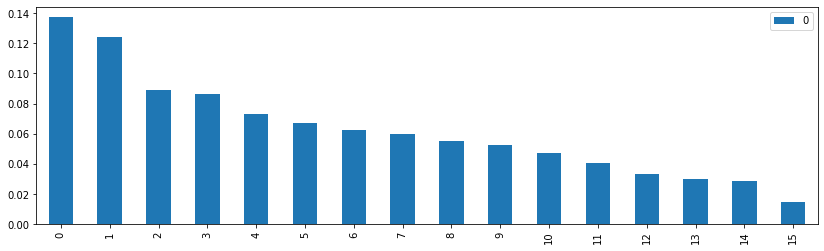

In [7]:
plt.rcParams["figure.figsize"] = (14,4)

numerical_features = [
    "track_duration_ms",
    "track_popularity",
    "track_explicit",
    "track_danceability",
    "track_energy",
    "track_key",
    "track_loudness",
    "track_mode",
    "track_speechiness",
    "track_acousticness",
    "track_instrumentalness",
    "track_liveness",
    "track_valence",
    "track_tempo",
    "track_time_signature",
    "album_release_timestamp"
] 
    
standardized_numerical_features = WoofBeats_df[numerical_features].apply(zscore)

pca = PCA(n_components=standardized_numerical_features.shape[1])
pca.fit(standardized_numerical_features)

reduced_numerical_features = pd.DataFrame(
    pca.transform(standardized_numerical_features),
    index=WoofBeats_df["track_id"]
)[[i for i, v in enumerate(pca.explained_variance_ratio_) if v > 0.05]]
pd.DataFrame(pca.explained_variance_ratio_).plot.bar()
reduced_numerical_features

# Apply Clustering and Create **theRes/*.v001** Playlists

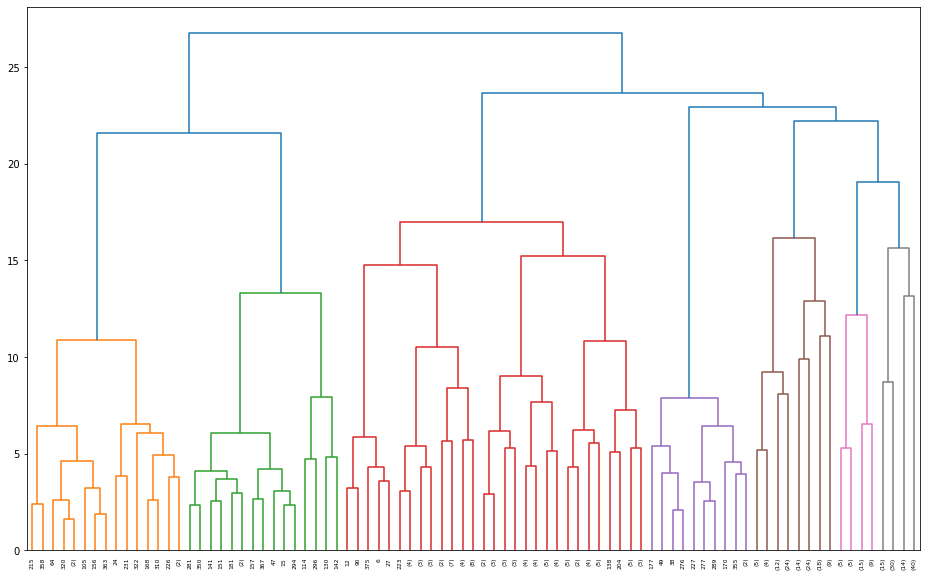

In [8]:
plt.rcParams["figure.figsize"] = (16,10)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(reduced_numerical_features)
plot_dendrogram(model, truncate_mode="level", p=6)
model = AgglomerativeClustering(n_clusters=6)
model = model.fit(reduced_numerical_features)

In [9]:
theRes_playlist = pd.DataFrame(
    model.labels_,
    columns = ["theRes_playlist_id"]
)
theRes_playlist = pd.concat(
    [theRes_playlist, WoofBeats_df],
    axis=1
)
theRes_playlist[theRes_playlist["theRes_playlist_id"]==1]

,theRes_playlist_id,track_id,track_name,track_duration_ms,track_popularity,track_explicit,track_danceability,track_energy,track_key,track_loudness,...,track_tempo,track_time_signature,album_name,album_release_timestamp,album_id,artist_id,artist_name,playlist_name,playlist_id,added_by
11,1,5qxChyzKLEyoPJ5qGrdurN,No Sleep Till Brooklyn,246933,68,True,0.712,0.691,8,-8.157,...,97.022,4,Licensed To Ill,5.323968e+08,11oR0ZuqB3ucZwb5TGbZxb,03r4iKL2g2442PT9n2UKsx,Beastie Boys,WoofBeats-2021-12,4Wj5LF1wo57BP6Fk2Itzk9,Dan
14,1,41r8mKvIbkQHLm5C9TaEJ6,Tenkkeys (Kklasikk Version),131397,41,True,0.768,0.810,1,-7.918,...,93.044,4,Tenkkeys (Kklasikk Version),1.473466e+09,6d7kzWOQC5vxa7moD4kZwu,0JXPiLgbGX4n86jsocSkG6,Spark Master Tape,WoofBeats-2021-12,4Wj5LF1wo57BP6Fk2Itzk9,davidmimorton
16,1,3jLHo30ucbkYY9P7v8leKh,Sea Sick,130714,60,False,0.817,0.577,6,-8.630,...,112.025,4,Sea Sick,1.567642e+09,2rW8WOaJP6R7rIFFaJEhoZ,2jbd7OqeJJd1hz81vOXwwW,binki,WoofBeats-2021-12,4Wj5LF1wo57BP6Fk2Itzk9,Dakota
19,1,7888F1QWPTn4cPbuknNV4T,HIT EM WHERE IT HURTS,165499,64,False,0.779,0.721,6,-6.371,...,178.046,4,HIT EM WHERE IT HURTS,1.600387e+09,2w4bxNOt8ZLIBaKH2oi6ij,23KIrX6iPiVOkx60F4bjNq,PawPaw Rod,WoofBeats-2021-12,4Wj5LF1wo57BP6Fk2Itzk9,davidmimorton
26,1,6tDDoYIxWvMLTdKpjFkc1B,telepatía,160191,83,False,0.653,0.524,11,-9.016,...,83.970,4,Sin Miedo (del Amor y Otros Demonios) ∞,1.607040e+09,00wSTrFxoSzA7eeS1UxHgd,1U1el3k54VvEUzo3ybLPlM,Kali Uchis,WoofBeats-2021-11,07NrtpvwnNcCGDUTKHvjIO,davidmimorton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,1,2DylrERZbUpx845Cd8y7hU,Kevin,199382,0,True,0.677,0.352,7,-9.083,...,101.992,4,Kevin,1.588205e+09,6rqZTOVumjrqnV4cT6i9xq,5ut4VhaCRPsEjAZ93jpPfK,Oliver Malcolm,WoofBeats-2020-12,26ytCXO4GPGK6MEr3uZojZ,Dakota
360,1,0P2Dxoy0mdzM9NlFQoLZbc,Hollywood (feat. Snoop Dogg & Jamie Principle),293493,57,True,0.685,0.631,7,-10.338,...,104.126,4,The Now Now,1.530230e+09,1amYhlukNF8WdaQC3gKkgL,3AA28KZvwAUcZuOKwyblJQ,Gorillaz,WoofBeats-2020-12,26ytCXO4GPGK6MEr3uZojZ,Dan
361,1,0JzPnwc3eDdyBeReXFLgXr,Look Easy,165219,51,True,0.718,0.637,1,-9.962,...,108.023,4,Look Easy,1.594339e+09,0XCbNyUbT3873z30JAwkbi,6qgnBH6iDM91ipVXv28OMu,KAYTRANADA,WoofBeats-2020-12,26ytCXO4GPGK6MEr3uZojZ,davidmimorton
371,1,531MBHrtGF6nAkK4zUafi9,Mutual Butterflies,183875,62,True,0.616,0.649,3,-5.133,...,78.131,4,august,1.535674e+09,7h1xc7a0GqmwkzOu29YbjD,5YHM0i7v5TqqibZhS0YiuX,Ryan Trey,WoofBeats-2020-12,26ytCXO4GPGK6MEr3uZojZ,Dakota


In [18]:
current_user_id = spotify.current_user()["id"]
for playlist_id in set(theRes_playlist["theRes_playlist_id"]):
    new_playlist = spotify.user_playlist_create(
        current_user_id,
        "theRes/cluster{}.v001".format(playlist_id)
    )
    track_ids = list(theRes_playlist[theRes_playlist["theRes_playlist_id"]==playlist_id]["track_id"])
    uploaded_tracks_count = 0
    page_size = 100
    while uploaded_tracks_count<=len(track_ids):
        end_of_page = min(len(track_ids),uploaded_tracks_count + page_size)
        spotify.playlist_add_items(
            new_playlist["id"],
            track_ids[uploaded_tracks_count:end_of_page]
        )
        uploaded_tracks_count += page_size

In [16]:
new_playlist["id"][uploaded_tracks_count:end_of_page]

'6SeCkynwZo5P8HZWhPi6lj'

In [17]:
uploaded_tracks_count

0